<a href="https://colab.research.google.com/github/Mingtorr/Mingtorr.github.io/blob/master/XOR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class Separator(nn.Module):
  def __init__(self):
    super(Separator, self).__init__()
    self.fc1 = nn.Linear(2, 4) #입력이 2개 출력이 4개
    self.fc2 = nn.Linear(4, 1)
  
  def forward(self, x): # 히든 레이어 하나
    x = self.fc1(x) 
    x = nn.functional.relu(x)
    x = self.fc2(x)
    x = torch.sigmoid(x)
    return x

In [4]:
class DataGenerator(Dataset):
  def __init__(self, type_, length, std=0.08):
    self.length = length
    if type_ == 'and':
      self.val_l = [0, 0, 0, 1]
    elif type_ == 'or':
      self.val_l = [0, 1, 1, 1]
    elif type_ == 'xor':
      self.val_l = [0, 1, 1, 0]
    else:
      self.val_l = [0, 0, 0, 0]
     
    self.dataset = []
    for i in range(length):
      x = np.random.normal(i%2, std)
      y = np.random.normal((i//2)%2, std)
      val = self.val_l[i%4]
      self.dataset.append((x, y, val))
      
  def get_dataset(self):
    return self.dataset
    
  def __len__(self):
    return self.length
    
  def __getitem__(self, idx):
    x, y, val = self.dataset[idx]
    return (torch.Tensor([x, y]), torch.Tensor([val]))

In [5]:
DATASET = DataGenerator('xor', 1000)
lr = 0.1 # learning rate
batch_size = 20 #한번에 몇번 골거냐
num_epochs = 10 # 전체를 몇번 반복할 건지
num_workers = 4 
graph_x = np.linspace(-1.0, 2, 2)

params = {
    'batch_size' : batch_size,
    'shuffle' : True,
    'num_workers' : num_workers
}

dataloader = DataLoader(DATASET, **params)
model = Separator().cuda()
optimizer = Adam(model.parameters(), lr=lr)

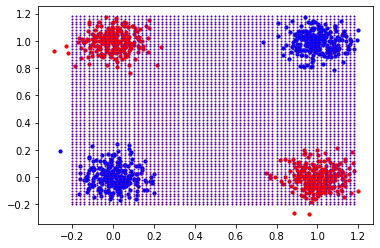

Loss : 0.07961
Loss : 0.00144
Loss : 0.00083
Loss : 0.00051
Loss : 0.00046


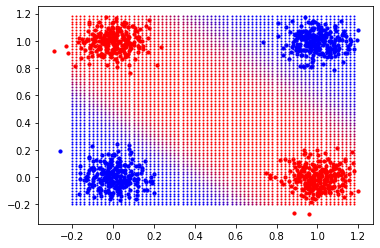

Loss : 0.00038
Loss : 0.00021
Loss : 0.00021
Loss : 0.00018
Loss : 0.00017


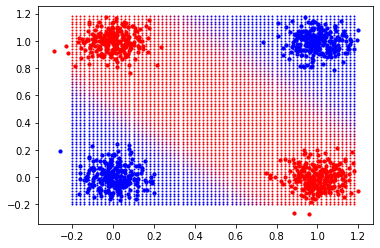

In [6]:
def show(model):
  for item in DATASET.get_dataset():
    x, y, val = item
    if val == 1:
      plt.scatter(x, y, c='red', s=10) # scatter 뿌리는 거
    else:
      plt.scatter(x, y, c='blue', s=10)
  for x in np.arange(-0.2, 1.2, 0.02):
    for y in np.arange(-0.2, 1.2, 0.02):
      val = model(torch.Tensor([x, y]).cuda())
      val = val.data.tolist()[0]
      plt.scatter(x, y, c=[[val, 0, 1-val]], s=1)
  plt.show()

show(model)
for epoch in range(num_epochs):
  total_loss = 0
  for x, val in dataloader:
    x = x.cuda() #쿠다에서 동작하도록 옮겨 주어라 # 이 데이터를 쿠다라는 gpu에 주어라
    val = val.cuda() 
    optimizer.zero_grad() # 돌때마다 옵티마이져를 0으로 만들어서 돌아라
    val_ =  model(x)
    loss = torch.sum(torch.pow(val - val_, 2))   # 제곱치하는거 오차 구하기
    
    loss.backward() # 로스를 이용해 다시 동작
    optimizer.step() #아담 같은 걸 써서 옵치마져 한다.
    total_loss += loss.item()
  print("Loss : {:.5f}".format(total_loss / len(DATASET)))
  
  if epoch % 5  == 4:
    show(model)